<a href="https://colab.research.google.com/github/costinean-sebastian-30126/Csharp_facultate/blob/main/Copy_of_Household_Power_Consumption_3aa570.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'electric-power-consumption-data-set:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F122%2F260%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240526%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240526T092950Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D857baed1572185de7ab35cca2c332639a87b003596d7b22fcb936f3fe24c10e335eae6207d21d0d7c410234e115c9675d5c97b7efd564f6b7b1f1afd1981b7b7989a20ef9b75bd7a393d9e1835678bc325fc1144335a93033bc42b4dff2b7709d9f7f86f4f0cce364f1664554ca4ef54236c691d020cc274159fb7cac81da3b6192103417eb69b39a98f21b7905d217909d28ab4afea6a79d2bcb9973bfd16d6e4248674e2bccba8012b84aaeffce36f8f64c429e740307d96fa6da70ae3db9c5575f6224b673ccb64373c3bcfdf6de83d868ee88a4130d95b2e6bd8100a3baa256c669683ba9323888b33549a174504e309057a585c6bcff0bc18676a01ebcb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Household Power Consumption - Clustering

## Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
power = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt',delimiter=';',low_memory=False)
power.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
print('Shape of Power Consumption Data:',power.shape)

Shape of Power Consumption Data: (2075259, 9)


In [ ]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


## Exploratory Data Analysis

### Null Values

In [ ]:
null_values = power.isna().sum()

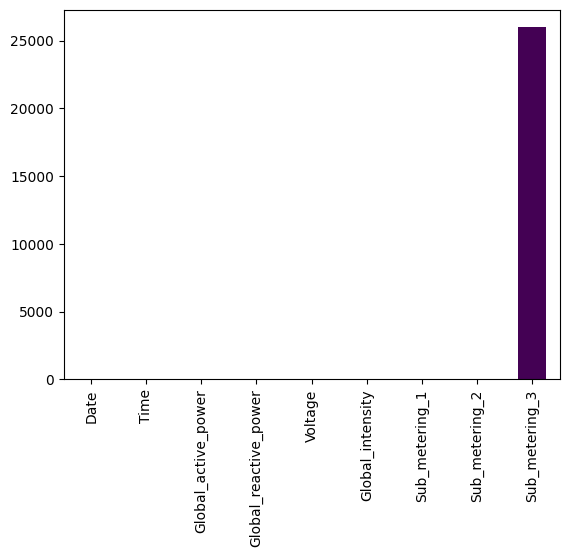

In [ ]:
null_values.plot(kind='bar',cmap='viridis')
plt.show()

### Replacing ? with null

In [ ]:
power.replace('?',pd.NA,inplace=True)

In [ ]:
null_values = power.isna().sum()

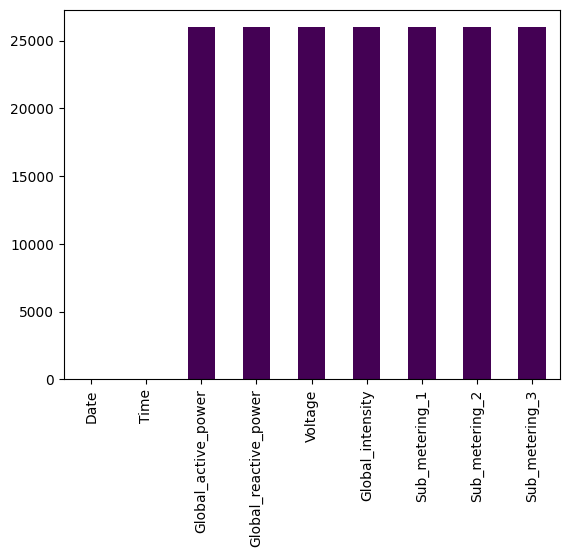

In [ ]:
null_values.plot(kind='bar',cmap='viridis')
plt.show()

In [ ]:
power.dropna(inplace=True)

In [ ]:
print('Shape of Power Consumption Data after removing null values:',power.shape)

Shape of Power Consumption Data after removing null values: (2049280, 9)


In [ ]:
power.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


### Changing dtypes of columns to float datatype

In [ ]:
power['Global_active_power'] = power['Global_active_power'].astype('float')
power['Global_reactive_power'] = power['Global_reactive_power'].astype('float')
power['Voltage'] = power['Voltage'].astype('float')
power['Global_intensity'] = power['Global_intensity'].astype('float')
power['Sub_metering_1'] = power['Sub_metering_1'].astype('float')
power['Sub_metering_2'] = power['Sub_metering_2'].astype('float')
power['Sub_metering_3'] = power['Sub_metering_3'].astype('float')

In [ ]:
power.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 156.3+ MB


In [ ]:
power.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


### Boxplot of Columns

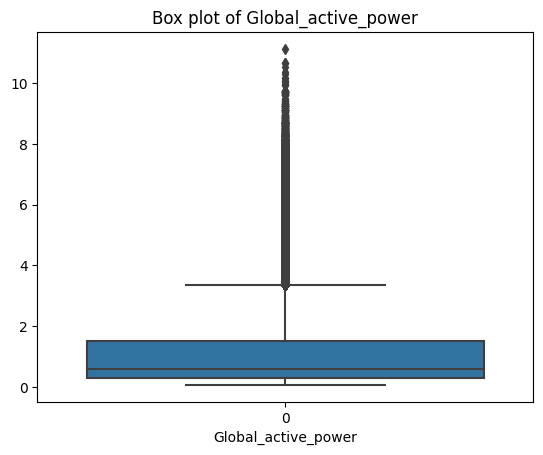

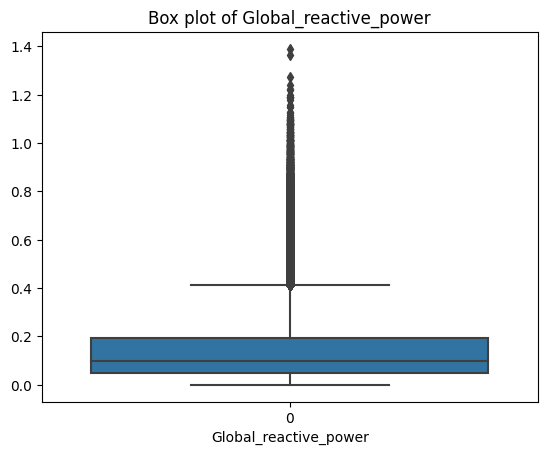

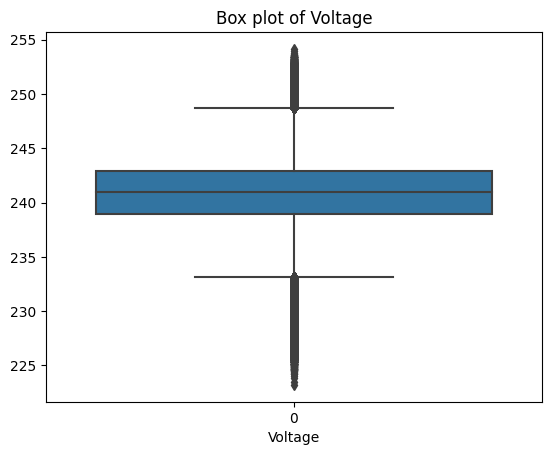

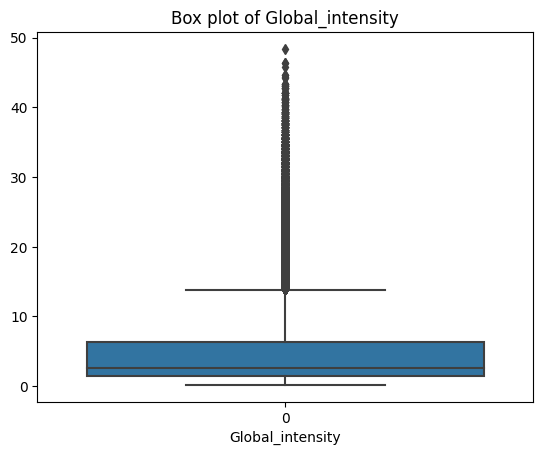

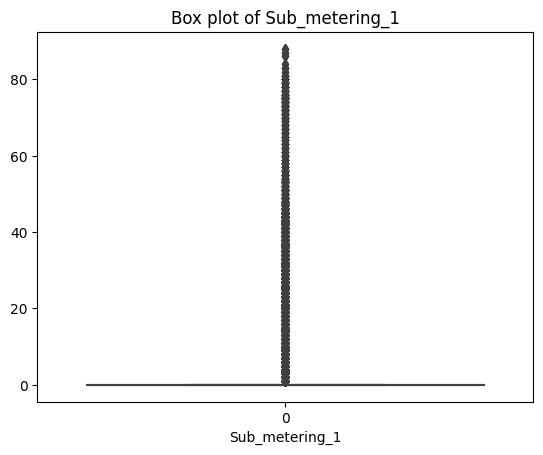

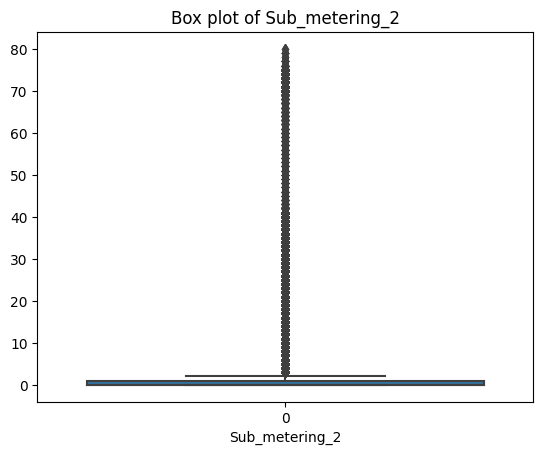

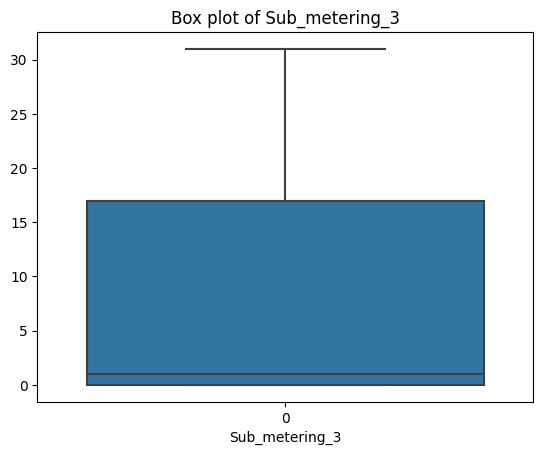

In [ ]:
cols = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']

for column in cols:
    sns.boxplot(power[column])
    plt.title(f'Box plot of {column}')
    plt.xlabel(f'{column}')
    plt.show()

### Preparing Summary DataFrame grouped by Date

In [ ]:
active_power = power.groupby('Date')['Global_active_power'].sum()
voltage_avg = power.groupby('Date')['Voltage'].mean()
intensity = power.groupby('Date')['Global_intensity'].sum()
submeter_1 = power.groupby('Date')['Sub_metering_1'].sum()
submeter_2 = power.groupby('Date')['Sub_metering_2'].sum()
submeter_3 = power.groupby('Date')['Sub_metering_3'].sum()

In [ ]:
total_energy = pd.merge(active_power,voltage_avg,on='Date',how='inner')

In [ ]:
total_energy_2 = total_energy.merge(intensity,on='Date',how='inner')
total_energy_3 = total_energy_2.merge(submeter_1,on='Date',how='inner')
total_energy_4 = total_energy_3.merge(submeter_2,on='Date',how='inner')
energy = total_energy_4.merge(submeter_3,on='Date',how='inner')

In [ ]:
energy.head()

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,
1/1/2007,2749.004,240.128979,11400.4,0.0,352.0,5880.0
1/1/2008,2759.738,241.036674,11489.2,2461.0,2739.0,12355.0
1/1/2009,1406.692,242.836062,5975.8,765.0,3845.0,2803.0
1/1/2010,1224.252,242.565722,5093.4,2304.0,327.0,3558.0
1/10/2007,1720.922,239.239917,7306.2,1507.0,6622.0,5960.0


## Preprocessing

In [ ]:
df_electric = energy.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

attributes = list(df_electric.columns)
num_pipeline = make_pipeline(StandardScaler())
preprocessing = ColumnTransformer([
    ('num',num_pipeline,attributes)
])

## PCA and KMeans

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = make_pipeline(preprocessing,PCA(n_components=.95))

In [ ]:
inertias = []
n_clusters = [2,3,4,5,6,7,8]

for cluster in n_clusters:
    kmeans_electric = make_pipeline(pca,KMeans(n_clusters=cluster,n_init='auto',random_state=42))
    kmeans_electric.fit(df_electric)
    inertias.append(kmeans_electric['kmeans'].inertia_)


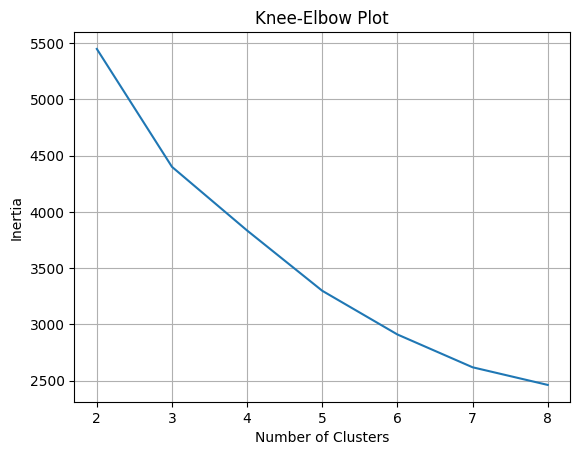

In [ ]:
plt.plot(n_clusters,inertias)
plt.title('Knee-Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Number of clusters chosen according to Knee-Elbow Plot = 3

In [ ]:
kmeans_e3 = make_pipeline(pca,KMeans(n_clusters=3,n_init='auto',random_state=42))
kmeans_e3.fit(df_electric)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Global_active_power',
                                                                    'Voltage',
                                                                    'Global_intensity',
                                                                    'Sub_metering_1',
                                                                    'Sub_metering_2',
                                                                    'Sub_metering_3'])])),
                                 ('pca', PCA(n_components=0.95))])),
                ('kmeans',
                 KMeans(n_clusters=3, n_init='auto', random_state=42))])

In [ ]:
energy['cluster'] = kmeans_e3['kmeans'].labels_

## Cluster Analysis

### Global Active Power

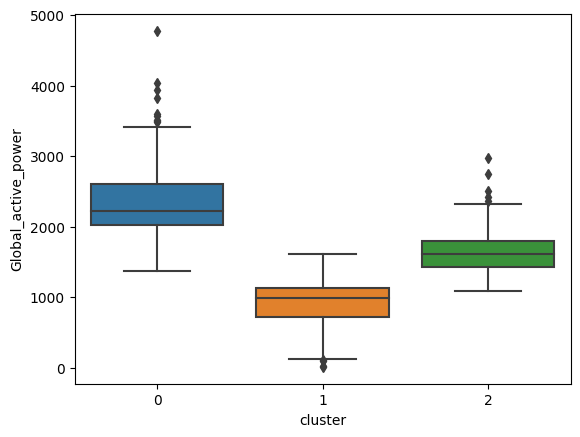

In [ ]:
sns.boxplot(data=energy,x='cluster',y='Global_active_power')
plt.show()

## Voltage

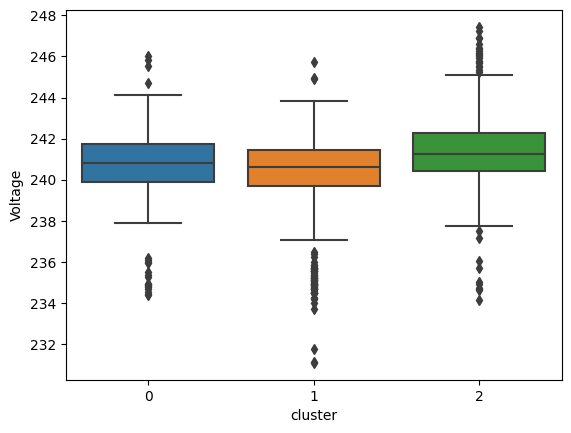

In [ ]:
sns.boxplot(data=energy,x='cluster',y='Voltage')
plt.show()

### Global Intensity

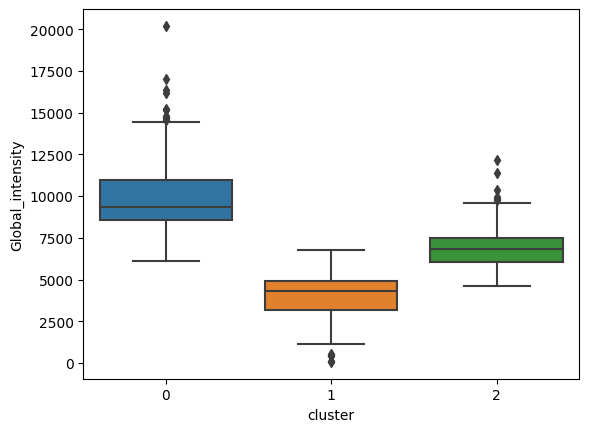

In [ ]:
sns.boxplot(data=energy,x='cluster',y='Global_intensity')
plt.show()

### Sub-metering-1

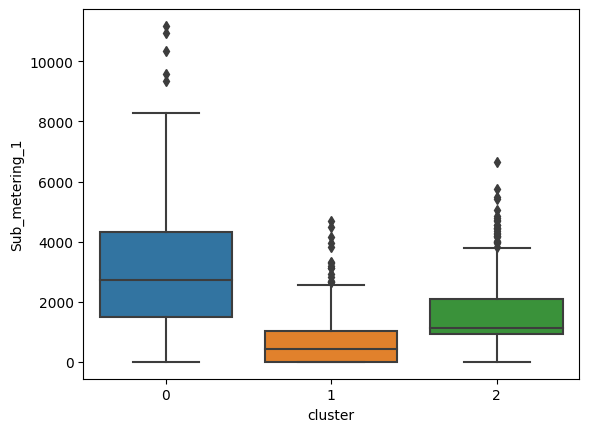

In [ ]:
sns.boxplot(data=energy,x='cluster',y='Sub_metering_1')
plt.show()

### Sub metering -2

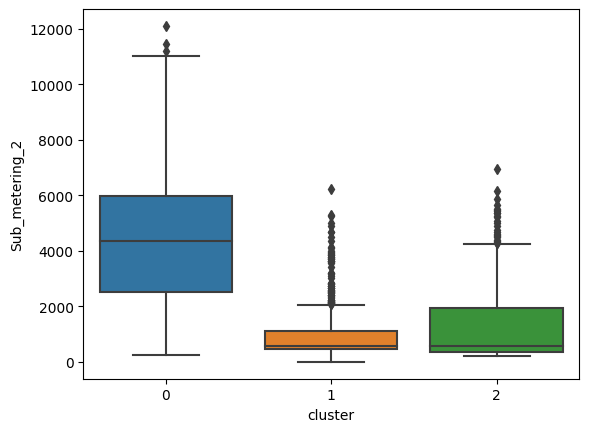

In [ ]:
sns.boxplot(data=energy,x='cluster',y='Sub_metering_2')
plt.show()

### Sub metering-3

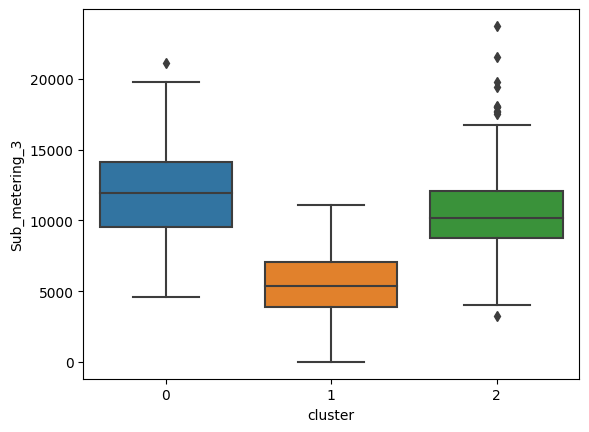

In [ ]:
sns.boxplot(data=energy,x='cluster',y='Sub_metering_3')
plt.show()

In [ ]:
cluster_0 = energy[energy.cluster == 0]
cluster_1 = energy[energy.cluster == 1]
cluster_2 = energy[energy.cluster == 2]

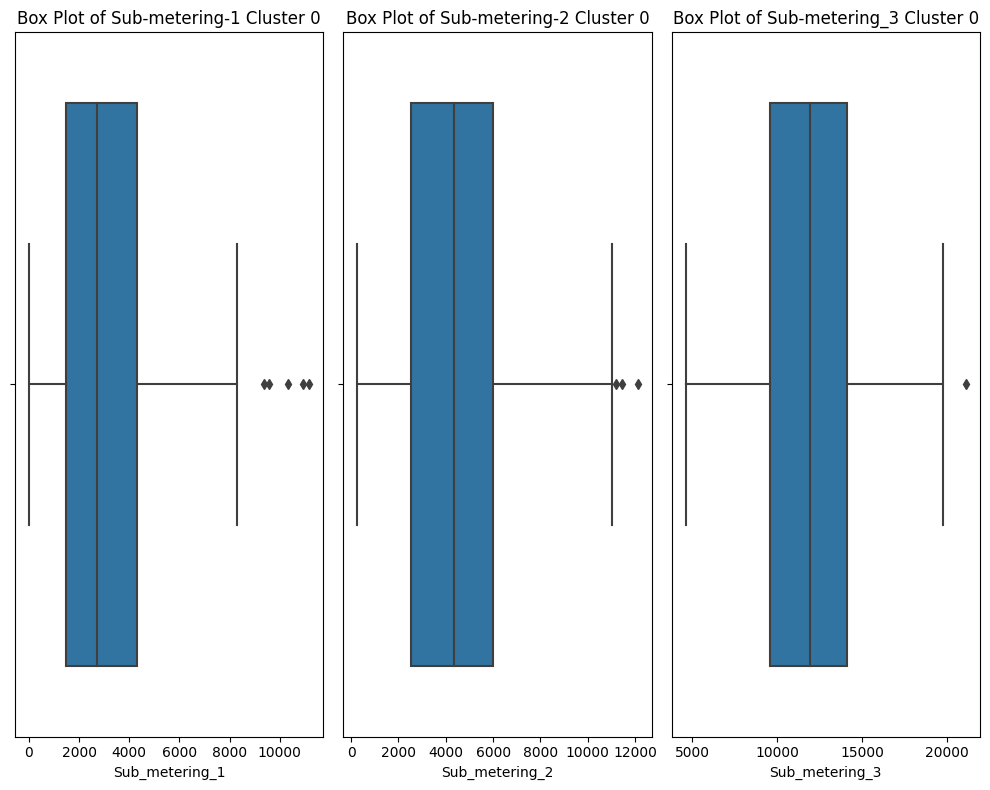

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(10,8))
sns.boxplot(data=cluster_0,x='Sub_metering_1',ax=axes[0])
axes[0].set_title('Box Plot of Sub-metering-1 Cluster 0')
sns.boxplot(data=cluster_0,x='Sub_metering_2',ax=axes[1])
axes[1].set_title('Box Plot of Sub-metering-2 Cluster 0')
sns.boxplot(data=cluster_0,x='Sub_metering_3',ax=axes[2])
axes[2].set_title('Box Plot of Sub-metering_3 Cluster 0')
plt.tight_layout()
plt.show()

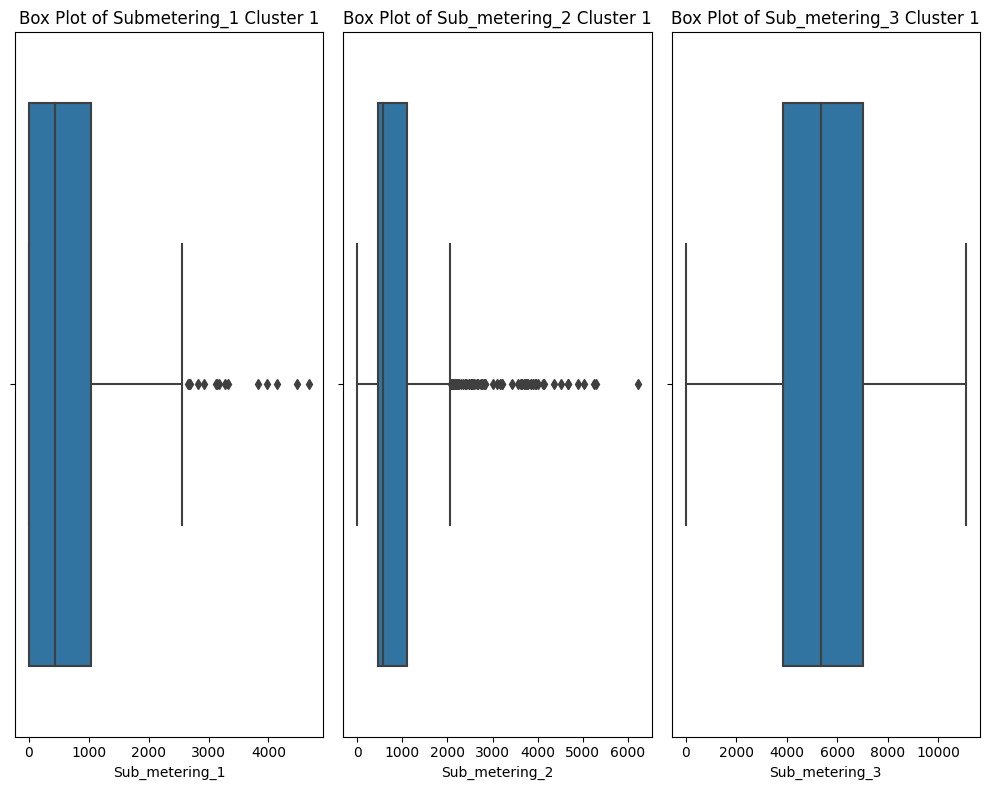

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(10,8))
sns.boxplot(data=cluster_1,x='Sub_metering_1',ax=axes[0])
axes[0].set_title('Box Plot of Submetering_1 Cluster 1')
sns.boxplot(data=cluster_1,x='Sub_metering_2',ax=axes[1])
axes[1].set_title('Box Plot of Sub_metering_2 Cluster 1')
sns.boxplot(data=cluster_1,x='Sub_metering_3',ax=axes[2])
axes[2].set_title('Box Plot of Sub_metering_3 Cluster 1')
plt.tight_layout()
plt.show()

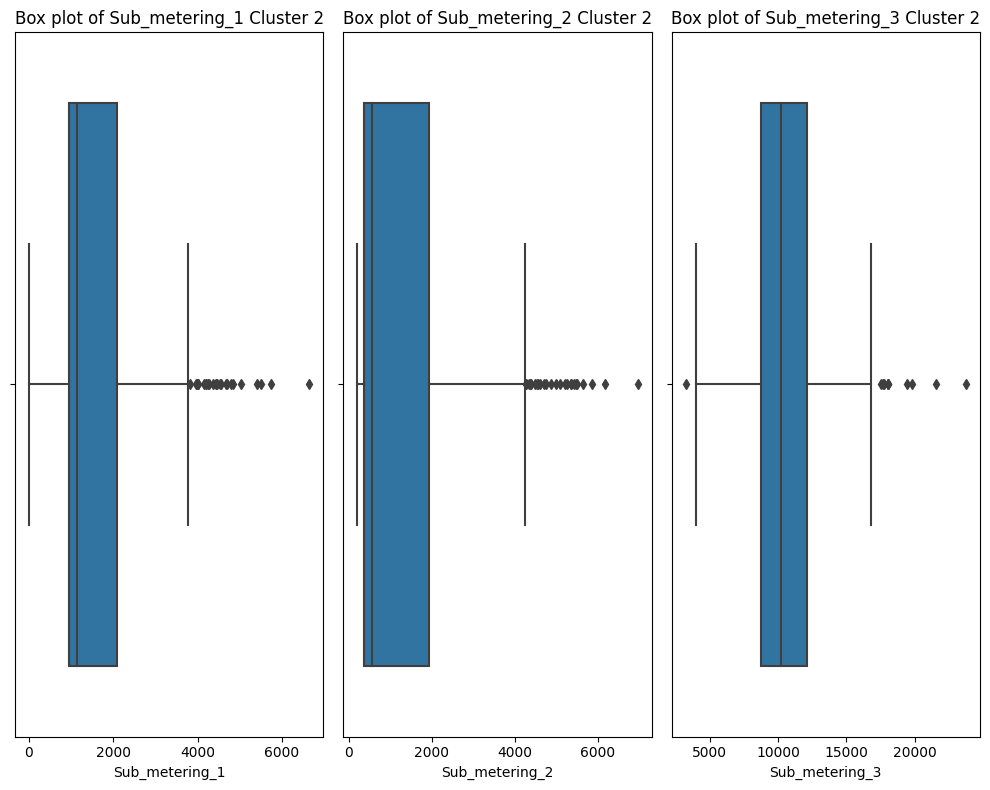

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(10,8))
sns.boxplot(data=cluster_2,x='Sub_metering_1',ax=axes[0])
axes[0].set_title('Box plot of Sub_metering_1 Cluster 2')
sns.boxplot(data=cluster_2,x='Sub_metering_2',ax=axes[1])
axes[1].set_title('Box plot of Sub_metering_2 Cluster 2')
sns.boxplot(data=cluster_2,x='Sub_metering_3',ax=axes[2])
axes[2].set_title('Box plot of Sub_metering_3 Cluster 2')
plt.tight_layout()
plt.show()

In [ ]:
energy_transformed = kmeans_e3.transform(df_electric)

In [ ]:
energy_transformed.shape

(1433, 3)

In [ ]:
df_transformed = pd.DataFrame(energy_transformed,columns=['transformed_1','transformed_2','transformed_3'])

In [ ]:
df_transformed.head()

,transformed_1,transformed_2,transformed_3
0,1.896758,3.221633,1.237446
1,1.022246,4.803915,2.687035
2,3.709953,2.225119,2.486092
3,4.104252,1.757268,2.191324
4,2.696069,3.330516,3.043796


In [ ]:
df_transformed['cluster'] = kmeans_e3['kmeans'].labels_

## Transformed Data Analysis

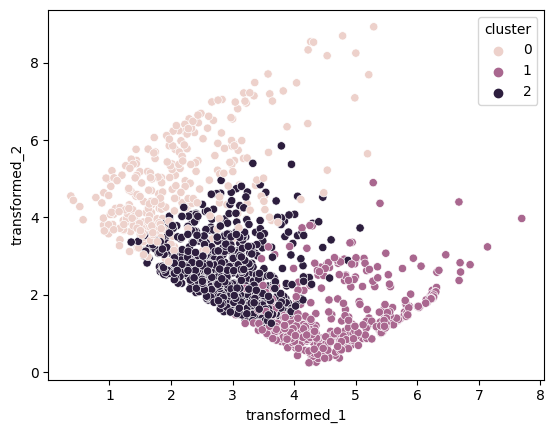

In [ ]:
sns.scatterplot(data=df_transformed,x='transformed_1',y='transformed_2',hue='cluster')
plt.show()

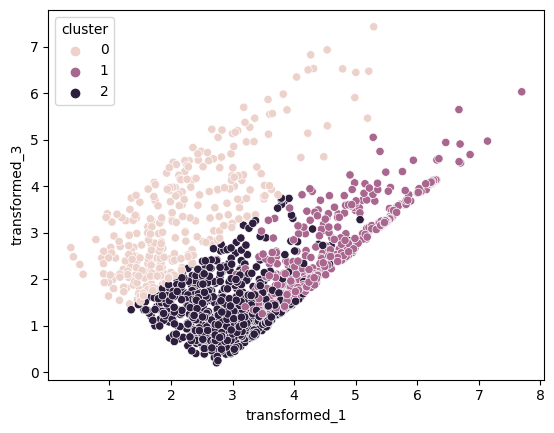

In [ ]:
sns.scatterplot(data=df_transformed,x='transformed_1',y='transformed_3',hue='cluster')
plt.show()

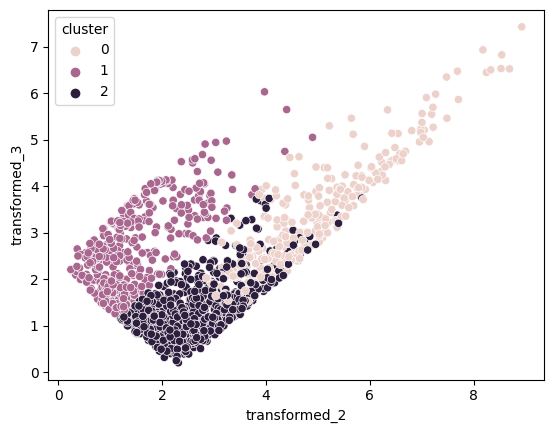

In [ ]:
sns.scatterplot(data=df_transformed,x='transformed_2',y='transformed_3',hue='cluster')
plt.show()

## Conclusion

### Cluster 0

It represents days having a High Active power,Medium Voltage and a High Global Intensity. The amount of energy consumed by Air Conditioner and Water heater were high. The energy consumed by the Kitchen and Laundry were higher than Clusters 1 and 2.

### Cluster 1

It represents days having a low Active Power,Medium Voltage and  low Global Intensity. The amount of energy consumed by Kitchen,Laundry,Air Conditioner and Water Heater were all low.

### Cluster 2

It represents days having a Medium Active Power,High Voltage and Medium Global Intensity. The amount of energy consumed by the Air conditioner and Water Heater was high. Kitchen and Laundry usage was low.

Detectarea sarcinii electrice și evenimentele de start și stop

Acest grafic prezintă detectarea sarcinii electrice într-o locuință și evenimentele de start și stop asociate

<ipython-input-12-9fa2e3e0ce5a>:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-12-9fa2e3e0ce5a>:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('household_power_consumption.txt', sep=';',


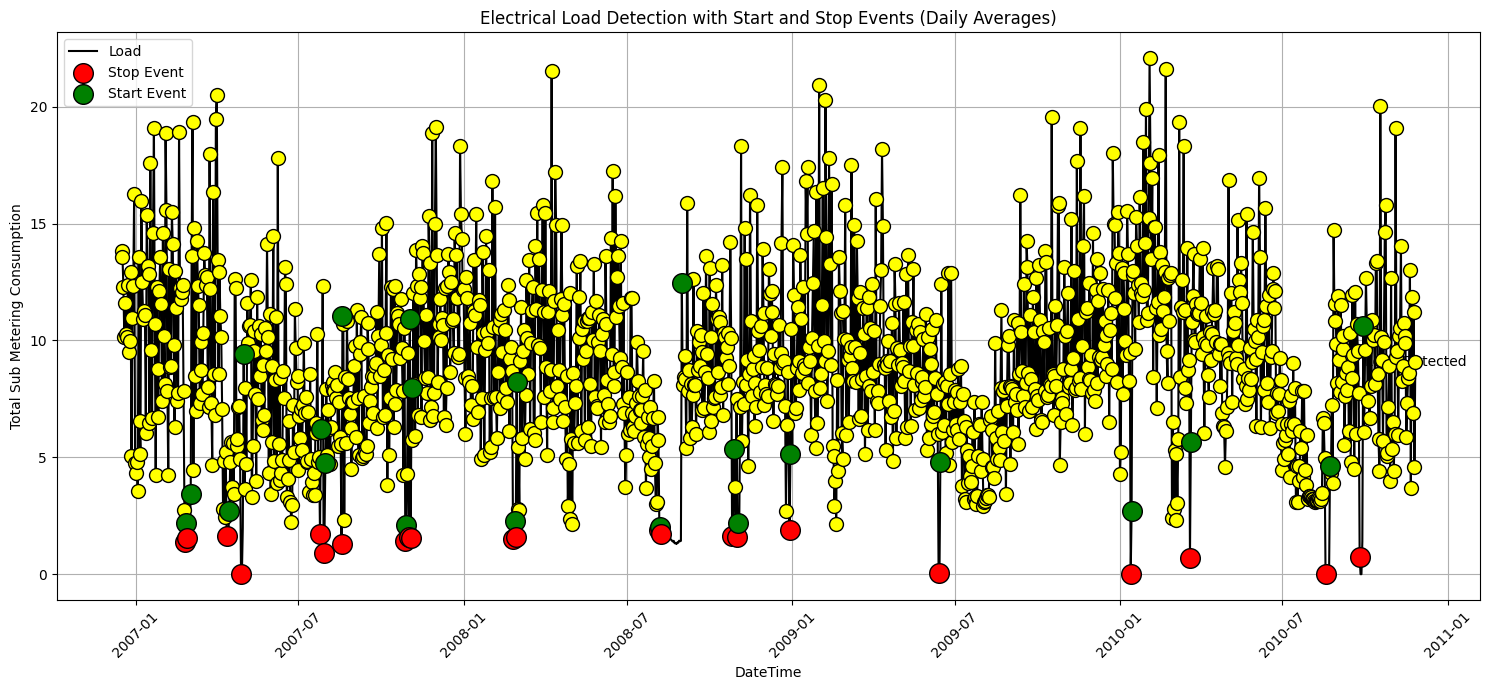

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Citește datele
data = pd.read_csv('household_power_consumption.txt', sep=';',
                   parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True,
                   low_memory=False, na_values=['nan','?'], index_col='DateTime')

# Selectează un subset din date pentru exemplificare
data_for_clustering = data[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].copy()
data_for_clustering['Total_sub_metering'] = data_for_clustering.sum(axis=1)

# Calculează media zilnică
daily_data = data_for_clustering.resample('D').mean()

# Detectarea sarcinii electrice
daily_data['Load_Detected'] = (daily_data['Total_sub_metering'] > 2.0).astype(int)
daily_data['Start_Event'] = (daily_data['Load_Detected'].diff() == 1).astype(int)
daily_data['Stop_Event'] = (daily_data['Load_Detected'].diff() == -1).astype(int)

# Plotare grafic
plt.figure(figsize=(15, 7))

# Adăugare linie pentru sarcina electrică
plt.plot(daily_data.index, daily_data['Total_sub_metering'], label='Load', color='black')

# Adăugare puncte pentru evenimente de start și stop
for i in range(len(daily_data)):
    if daily_data['Start_Event'].iloc[i] == 1:
        plt.scatter(daily_data.index[i], daily_data['Total_sub_metering'].iloc[i],
                    color='green', edgecolors='black', s=200, zorder=5, label='Start Event')
    if daily_data['Stop_Event'].iloc[i] == 1:
        plt.scatter(daily_data.index[i], daily_data['Total_sub_metering'].iloc[i],
                    color='red', edgecolors='black', s=200, zorder=5, label='Stop Event')
    if daily_data['Load_Detected'].iloc[i] == 1 and daily_data['Total_sub_metering'].iloc[i] > 2.0:
        # Adăugarea punctelor galbene doar pentru zilele cu consum mare de energie
        plt.scatter(daily_data.index[i], daily_data['Total_sub_metering'].iloc[i],
                    color='yellow', edgecolors='black', s=100, zorder=4)

# Adăugare legenda cu etichetele corecte
plt.text(daily_data.index[-1], daily_data['Total_sub_metering'].iloc[-1], 'Load Detected',
         ha='center', va='center', color='black')

plt.title('Electrical Load Detection with Start and Stop Events (Daily Averages)')
plt.xlabel('DateTime')
plt.ylabel('Total Sub Metering Consumption')

# Afișare legenda fără duplicare
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Distribuția Consumului Zilnic de Energie Electrică și Clusterizarea Utilizând Algoritmul KMeans"​

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


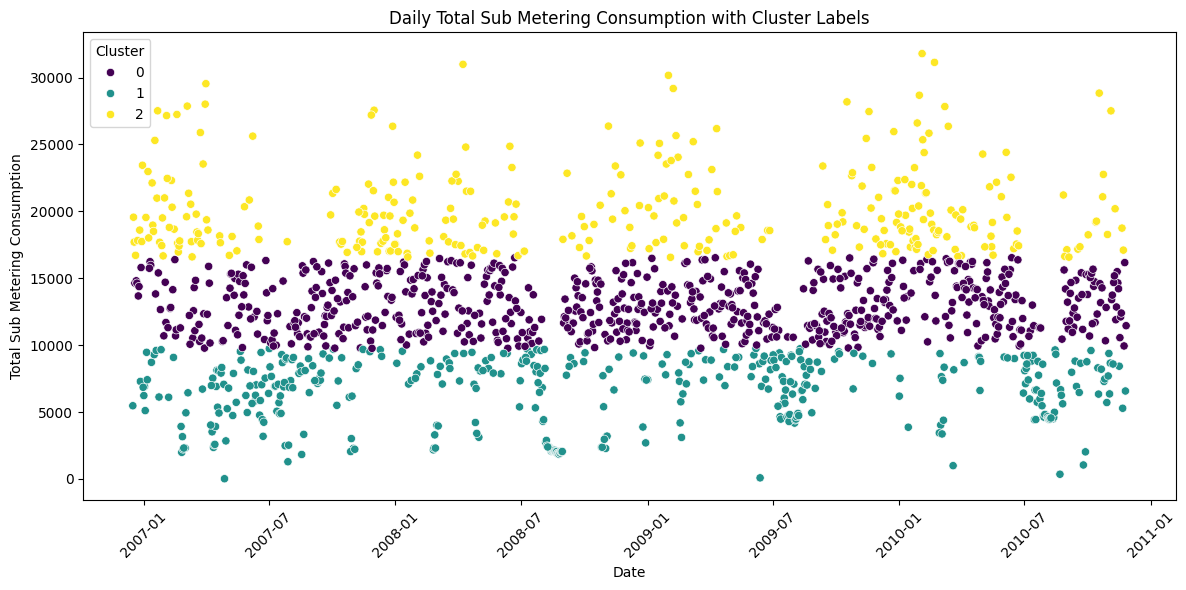

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Încărcarea datelor
power = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)

# Eliminarea valorilor lipsă
power.replace('?', pd.NA, inplace=True)
power.dropna(inplace=True)

# Convertirea datelor la tipuri numerice
power['Global_active_power'] = power['Global_active_power'].astype('float')
power['Sub_metering_1'] = power['Sub_metering_1'].astype('float')
power['Sub_metering_2'] = power['Sub_metering_2'].astype('float')
power['Sub_metering_3'] = power['Sub_metering_3'].astype('float')

# Sumarea consumului de energie electrică pentru cele 3 sub-metri pentru fiecare zi
power['Total_sub_metering'] = power['Sub_metering_1'] + power['Sub_metering_2'] + power['Sub_metering_3']

# Selecția datelor necesare pentru clustering
data_for_clustering = power[['Date', 'Total_sub_metering']]

# Calcularea consumului total de energie electrică pe zi
daily_consumption = data_for_clustering.groupby('Date')['Total_sub_metering'].sum().reset_index()
daily_consumption['Date'] = pd.to_datetime(daily_consumption['Date'], format='%d/%m/%Y')

# Crearea și ajustarea modelului KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(daily_consumption[['Total_sub_metering']])

# Adăugarea etichetelor de cluster la datele zilnice
daily_consumption['Cluster'] = kmeans.labels_

# Vizualizarea rezultatelor clustering-ului
plt.figure(figsize=(12, 6))
sns.scatterplot(data=daily_consumption, x='Date', y='Total_sub_metering', hue='Cluster', palette='viridis', legend='full')
plt.title('Daily Total Sub Metering Consumption with Cluster Labels')
plt.xlabel('Date')
plt.ylabel('Total Sub Metering Consumption')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
